In [70]:
import os
import re
import sys
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import table
from sklearn.metrics import cohen_kappa_score as cks
from tabulate import tabulate

from IPython.display import display

### Reading the data from 1st and 2nd rounds

In [2]:
datapath = '../data/'

In [3]:
df_round1 = pd.read_hdf(os.path.join(datapath,'df_labeling.hdf'), key='round1')
df_round2 = pd.read_hdf(os.path.join(datapath,'df_labeling.hdf'), key='round2')

In [4]:
df_round1.user = df_round1.user.apply(lambda x:x + "1")
df_round1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5880 entries, 0 to 451
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   task        5880 non-null   int64         
 1   user        5880 non-null   object        
 2   date        5880 non-null   datetime64[ns]
 3   image name  5880 non-null   object        
 4   id_image    5880 non-null   int16         
 5   class       5880 non-null   object        
 6   round       5880 non-null   int64         
dtypes: datetime64[ns](1), int16(1), int64(2), object(3)
memory usage: 333.0+ KB


In [5]:
df_round2.user = df_round2.user.apply(lambda x:x + "2")
df_round2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5880 entries, 0 to 391
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   task        5880 non-null   int64         
 1   user        5880 non-null   object        
 2   date        5880 non-null   datetime64[ns]
 3   image name  5880 non-null   object        
 4   id_image    5880 non-null   int16         
 5   class       5880 non-null   object        
 6   round       5880 non-null   int64         
dtypes: datetime64[ns](1), int16(1), int64(2), object(3)
memory usage: 333.0+ KB


In [6]:
df = pd.concat([df_round1, df_round2])
df['id_image'] = pd.Categorical(df['image name']).codes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11760 entries, 0 to 391
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   task        11760 non-null  int64         
 1   user        11760 non-null  object        
 2   date        11760 non-null  datetime64[ns]
 3   image name  11760 non-null  object        
 4   id_image    11760 non-null  int16         
 5   class       11760 non-null  object        
 6   round       11760 non-null  int64         
dtypes: datetime64[ns](1), int16(1), int64(2), object(3)
memory usage: 666.1+ KB


In [7]:
df.head()

,task,user,date,image name,id_image,class,round
0,1,Amelie1,2020-08-09,203-resource_document_zuiderzeemuseum_B001601_...,87,Non-Fruits,1
1,1,Amelie1,2020-08-09,285-gam19649_1.jpeg,232,Fruits,1
2,1,Amelie1,2020-08-09,07101-O_389_1.jpeg,6,Fruits,1
3,1,Amelie1,2020-08-09,07101-O_927_1.jpeg,12,Fruits,1
4,1,Amelie1,2020-08-09,07101-O_957_1.jpeg,13,Non-Fruits,1


In [8]:
df['class'].unique()

array(['Non-Fruits', 'Fruits', 'Informal', 'Formal', 'Appealing',
       'Non-appealing'], dtype=object)

In [9]:
len(df['id_image'].unique())

392

### Analysing the [inter-annotator agreement](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) on the results

In [38]:
l1 = df.user.unique()
iter_users = list(itertools.product(l1,l1))

In [41]:
results = []
for task in df.task.unique():
    df_iaa = pd.DataFrame(index=l1, columns=l1)
    for user1,user2 in iter_users:
        classesA = df.loc[(df.user == user1) & (df.task == task),['id_image', 'class']]
        classesA.sort_values(by=['id_image'], inplace=True)

        classesB = df.loc[(df.user == user2) & (df.task == task),['id_image', 'class']]
        classesB.sort_values(by=['id_image'], inplace=True)
        
        classesAB = pd.merge(classesA, classesB, on=['id_image'])
        classesAB.drop_duplicates(subset='id_image', keep = 'first', inplace=True) 
        classesAB.drop('id_image', axis=1, inplace=True)
        classesAB.dropna(inplace=True)

        agreement = cks(classesAB['class_x'], classesAB['class_y'])
        #df_iaa.loc[user1,user2] = f'{agreement:.2f}/({len(classesAB)})'
        df_iaa.loc[user1,user2] = f'{agreement:.3f}'
        df_iaa = df_iaa.apply(pd.to_numeric)
        df_iaa.index.name = f'Task_{task}'
    results.append(df_iaa)
    print(tabulate(df_iaa, headers='keys', tablefmt='psql'))
    print()

+------------+-----------+----------+-----------+-----------+--------------+-----------+----------+-----------+-----------+--------------+
| Task_1     |   Amelie1 |   Gerda1 |   Marcos1 |   Renato1 |   Yalemisew1 |   Amelie2 |   Gerda2 |   Marcos2 |   Renato2 |   Yalemisew2 |
|------------+-----------+----------+-----------+-----------+--------------+-----------+----------+-----------+-----------+--------------|
| Amelie1    |     1     |    0.928 |     0.892 |     0.907 |        0.886 |     0.928 |    0.912 |     0.882 |     0.897 |        0.872 |
| Gerda1     |     0.928 |    1     |     0.892 |     0.938 |        0.897 |     0.917 |    0.932 |     0.902 |     0.907 |        0.892 |
| Marcos1    |     0.892 |    0.892 |     1     |     0.923 |        0.923 |     0.923 |    0.887 |     0.939 |     0.913 |        0.898 |
| Renato1    |     0.907 |    0.938 |     0.923 |     1     |        0.918 |     0.928 |    0.902 |     0.923 |     0.938 |        0.913 |
| Yalemisew1 |     0.886 | 

In [74]:
cm = sns.light_palette("green", as_cmap=True)
cm = 'viridis'
cm = 'plasma'
cm = 'magma'
for df in results:
    s = df.style.background_gradient(cmap=cm, vmin=0, vmax=1, axis=None)
    #s = df.style.highlight_max().format(None, na_rep="-")
    #s = df.style.background_gradient(cmap='viridis')
    display(s)

,Amelie1,Gerda1,Marcos1,Renato1,Yalemisew1,Amelie2,Gerda2,Marcos2,Renato2,Yalemisew2
Task_1,,,,,,,,,,
Amelie1,1.000000,0.928000,0.892000,0.907000,0.886000,0.928000,0.912000,0.882000,0.897000,0.872000
Gerda1,0.928000,1.000000,0.892000,0.938000,0.897000,0.917000,0.932000,0.902000,0.907000,0.892000
Marcos1,0.892000,0.892000,1.000000,0.923000,0.923000,0.923000,0.887000,0.939000,0.913000,0.898000
Renato1,0.907000,0.938000,0.923000,1.000000,0.918000,0.928000,0.902000,0.923000,0.938000,0.913000
Yalemisew1,0.886000,0.897000,0.923000,0.918000,1.000000,0.928000,0.881000,0.923000,0.907000,0.923000
Amelie2,0.928000,0.917000,0.923000,0.928000,0.928000,1.000000,0.943000,0.913000,0.928000,0.913000
Gerda2,0.912000,0.932000,0.887000,0.902000,0.881000,0.943000,1.000000,0.886000,0.912000,0.866000
Marcos2,0.882000,0.902000,0.939000,0.923000,0.923000,0.913000,0.886000,1.000000,0.923000,0.928000
Renato2,0.897000,0.907000,0.913000,0.938000,0.907000,0.928000,0.912000,0.923000,1.000000,0.913000


,Amelie1,Gerda1,Marcos1,Renato1,Yalemisew1,Amelie2,Gerda2,Marcos2,Renato2,Yalemisew2
Task_2,,,,,,,,,,
Amelie1,1.000000,0.330000,0.252000,0.316000,-0.091000,0.182000,-0.354000,0.078000,0.150000,-0.115000
Gerda1,0.330000,1.000000,0.210000,0.306000,0.153000,0.322000,-0.102000,0.117000,0.110000,0.149000
Marcos1,0.252000,0.210000,1.000000,0.051000,-0.031000,-0.011000,-0.307000,0.098000,-0.049000,-0.044000
Renato1,0.316000,0.306000,0.051000,1.000000,-0.028000,0.287000,-0.014000,0.117000,0.439000,0.019000
Yalemisew1,-0.091000,0.153000,-0.031000,-0.028000,1.000000,0.048000,0.207000,0.115000,-0.064000,0.186000
Amelie2,0.182000,0.322000,-0.011000,0.287000,0.048000,1.000000,0.168000,0.216000,0.255000,0.167000
Gerda2,-0.354000,-0.102000,-0.307000,-0.014000,0.207000,0.168000,1.000000,0.188000,0.095000,0.419000
Marcos2,0.078000,0.117000,0.098000,0.117000,0.115000,0.216000,0.188000,1.000000,0.094000,0.358000
Renato2,0.150000,0.110000,-0.049000,0.439000,-0.064000,0.255000,0.095000,0.094000,1.000000,0.089000


,Amelie1,Gerda1,Marcos1,Renato1,Yalemisew1,Amelie2,Gerda2,Marcos2,Renato2,Yalemisew2
Task_3,,,,,,,,,,
Amelie1,1.000000,0.659000,0.296000,0.534000,0.317000,0.658000,0.468000,0.416000,0.455000,0.344000
Gerda1,0.659000,1.000000,0.325000,0.453000,0.268000,0.729000,0.510000,0.423000,0.435000,0.279000
Marcos1,0.296000,0.325000,1.000000,0.424000,0.370000,0.339000,0.312000,0.454000,0.423000,0.339000
Renato1,0.534000,0.453000,0.424000,1.000000,0.454000,0.544000,0.566000,0.409000,0.691000,0.451000
Yalemisew1,0.317000,0.268000,0.370000,0.454000,1.000000,0.313000,0.402000,0.318000,0.441000,0.665000
Amelie2,0.658000,0.729000,0.339000,0.544000,0.313000,1.000000,0.472000,0.396000,0.526000,0.336000
Gerda2,0.468000,0.510000,0.312000,0.566000,0.402000,0.472000,1.000000,0.346000,0.565000,0.454000
Marcos2,0.416000,0.423000,0.454000,0.409000,0.318000,0.396000,0.346000,1.000000,0.326000,0.346000
Renato2,0.455000,0.435000,0.423000,0.691000,0.441000,0.526000,0.565000,0.326000,1.000000,0.439000


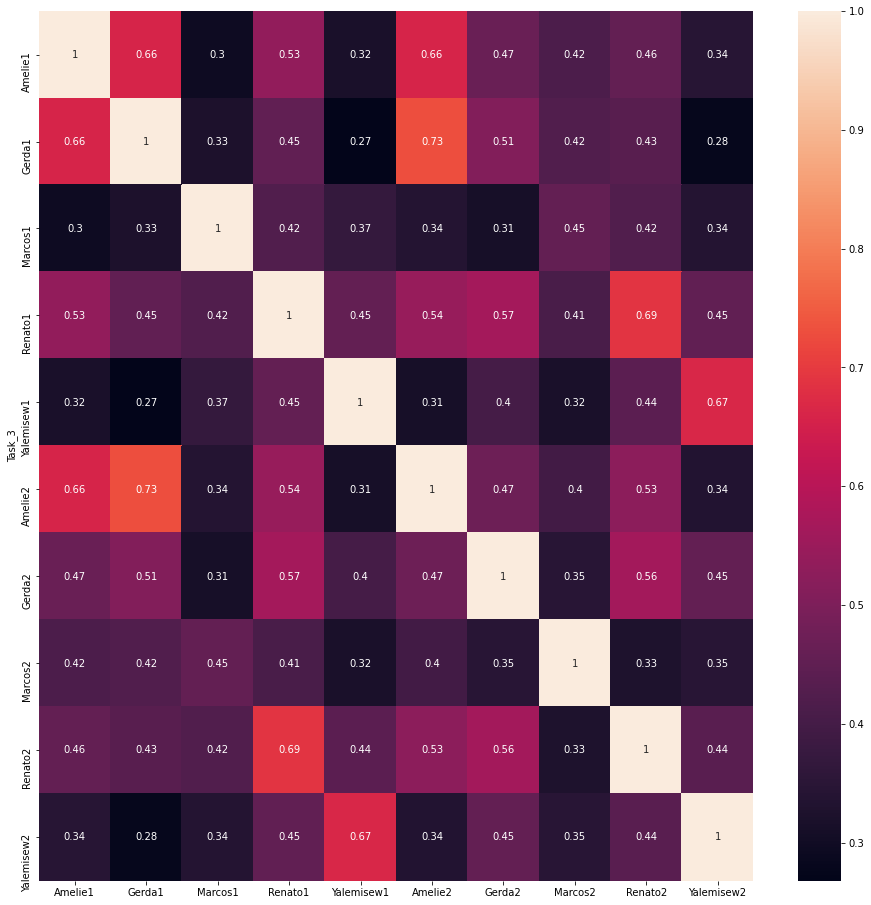

In [81]:
plt.subplots(figsize=(16,16))
ax = sns.heatmap(df, annot=True,)
plt.savefig('mytable.png')